In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [4]:
import requests
import urllib
from bs4 import BeautifulSoup
import re
import io
import gzip
import time
import csv
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from multiprocessing import Pool
import pandas as pd
from ipynb.fs.full.scrape_daily import scrape_daily

driver = webdriver.Chrome(ChromeDriverManager().install())
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
driver.get(url)

symbols = list()
symbols_GICC = dict()

table = "/html/body/div[3]/div[3]/div[5]/div[1]/table[1]"
table = driver.find_element_by_xpath(table)
elements = table.find_elements_by_tag_name("tr")[1:]

for row in elements:
    data = [data.text for data in row.find_elements_by_tag_name("td")]
    symbols.append(data[0])
    symbols_GICC[data[0]] = data[3]

print(len(symbols_GICC))



====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472
Driver [/Users/pemawangmo/.wdm/drivers/chromedriver/mac64/91.0.4472.101/chromedriver] found in cache


====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472


505


Driver [/Users/pemawangmo/.wdm/drivers/chromedriver/mac64/91.0.4472.101/chromedriver] found in cache


505


In [56]:
top_gain_loss_daily = pd.DataFrame(columns=["symbol","gain_loss","GICS"])
top_gain_loss_weekly = pd.DataFrame(columns=["symbol","gain_loss","GICS"])
top_gain_loss_monthly = pd.DataFrame(columns=["symbol","gain_loss","GICS"])

In [57]:
daily_dfs = {}
weekly_dfs = {}
monthly_dfs = {}


def gain_loss(sym):
    df_daily = pd.read_csv(sym +"_daily" + ".csv")
    df_daily["Gain/Loss"] = (df_daily["Close"] - df_daily["Close"].shift(1)) / df_daily["Close"]
    daily_dfs[sym] = df_daily

    df_weekly = pd.read_csv(sym +"_weekly"+".csv")
    df_weekly["Gain/Loss"] = (df_weekly["Close"] - df_weekly["Close"].shift(1)) / df_weekly["Close"]
    weekly_dfs[sym] = df_weekly

    df_monthly = pd.read_csv(sym + "_monthly" + ".csv")
    df_monthly["Gain/Loss"] = (df_monthly["Close"] - df_monthly["Close"].shift(1)) / df_weekly["Close"]
    monthly_dfs[sym] = df_monthly
    
    daily = {"symbol":sym,"gain_loss":df_daily["Gain/Loss"].sum(),"GICS":symbols_GICC[sym]}
    weekly = {"symbol":sym,"gain_loss":df_weekly["Gain/Loss"].sum(),"GICS":symbols_GICC[sym]}
    monthly = {"symbol":sym,"gain_loss":df_monthly["Gain/Loss"].sum(),"GICS":symbols_GICC[sym]}
    return (daily,weekly,monthly)

In [58]:
for n in symbols:
    try:
        (daily,weekly,monthly) = gain_loss(n)
        top_gain_loss_daily = top_gain_loss_daily.append(daily, ignore_index=True)
        top_gain_loss_weekly = top_gain_loss_weekly.append(weekly, ignore_index=True)
        top_gain_loss_monthly = top_gain_loss_monthly.append(monthly, ignore_index=True)
    except Exception as e :
        pass

In [59]:
print(top_gain_loss_daily)
print(top_gain_loss_weekly)
print(top_gain_loss_monthly)


    symbol  gain_loss                    GICS
0      MMM   0.022650             Industrials
1      ABT   0.775921             Health Care
2     ABBV   0.402984             Health Care
3     ABMD   0.868232             Health Care
4      ACN   0.782966  Information Technology
..     ...        ...                     ...
498    YUM   0.583798  Consumer Discretionary
499   ZBRA   1.346326  Information Technology
500    ZBH   0.188923             Health Care
501   ZION   0.168076              Financials
502    ZTS   1.091191             Health Care

[503 rows x 3 columns]
    symbol  gain_loss                    GICS
0      MMM   0.076890             Industrials
1      ABT   0.847760             Health Care
2     ABBV   0.435138             Health Care
3     ABMD   0.891735             Health Care
4      ACN   0.828857  Information Technology
..     ...        ...                     ...
498    YUM   0.610208  Consumer Discretionary
499   ZBRA   1.461277  Information Technology
500    ZBH

In [60]:
top_gain_loss_daily = top_gain_loss_daily.sort_values(by=["gain_loss"])
top_25_daily = top_gain_loss_daily.head(25)
loss_25_daily = top_gain_loss_daily.tail(25)
top_25_daily_names = list(top_25_daily["symbol"])
loss_25_daily_names = list(loss_25_daily["symbol"])
names = set(loss_25_daily_names+top_25_daily_names)
samp = pd.DataFrame(columns=names,index=names)
for n1,n2 in combinations(names,2):
    df1 = daily_dfs[n1]
    df2 = daily_dfs[n2]
    samp.loc[n1,n2] = df1["Gain/Loss"].corr(df2["Gain/Loss"])
    samp.loc[n2,n1] = df2["Gain/Loss"].corr(df1["Gain/Loss"])
    samp.loc[n1,n1] = 1
    samp.loc[n2,n2] = 1
daily_samp = samp.astype({name:"float" for name in names})
daily_samp.style.background_gradient(cmap="brg")

In [61]:
top_gain_loss_weekly = top_gain_loss_weekly.sort_values(by=["gain_loss"])
top_25_daily = top_gain_loss_weekly.head(25)
loss_25_daily = top_gain_loss_weekly.tail(25)
top_25_daily_names = list(top_25_daily["symbol"])
loss_25_daily_names = list(loss_25_daily["symbol"])
names = set(loss_25_daily_names+top_25_daily_names)
samp = pd.DataFrame(columns=names,index=names)
for n1,n2 in combinations(names,2):
    df1 = daily_dfs[n1]
    df2 = daily_dfs[n2]
    samp.loc[n1,n2] = df1["Gain/Loss"].corr(df2["Gain/Loss"])
    samp.loc[n2,n1] = df2["Gain/Loss"].corr(df1["Gain/Loss"])
    samp.loc[n1,n1] = 1
    samp.loc[n2,n2] = 1
weekly_samp = samp.astype({name:"float" for name in names})
weekly_samp.style.background_gradient(cmap="brg")

In [62]:
top_gain_loss_monthly = top_gain_loss_monthly.sort_values(by=["gain_loss"])
top_25_daily = top_gain_loss_monthly.head(25)
loss_25_daily = top_gain_loss_monthly.tail(25)
top_25_daily_names = list(top_25_daily["symbol"])
loss_25_daily_names = list(loss_25_daily["symbol"])
names = set(loss_25_daily_names+top_25_daily_names)
samp = pd.DataFrame(columns=names,index=names)
for n1,n2 in combinations(names,2):
    df1 = daily_dfs[n1]
    df2 = daily_dfs[n2]
    samp.loc[n1,n2] = df1["Gain/Loss"].corr(df2["Gain/Loss"])
    samp.loc[n2,n1] = df2["Gain/Loss"].corr(df1["Gain/Loss"])
    samp.loc[n1,n1] = 1
    samp.loc[n2,n2] = 1
monthly_samp = samp.astype({name:"float" for name in names})
monthly_samp.style.background_gradient(cmap="brg")

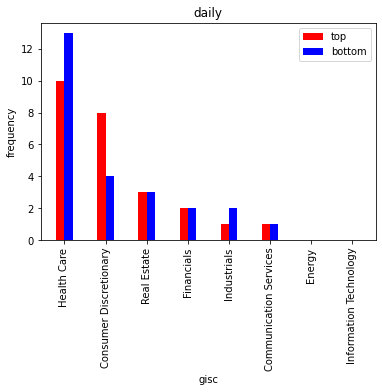

In [63]:
top_25 = dict(top_gain_loss_daily["GICS"].head(25).value_counts())
bottom_25 = dict(top_gain_loss_daily["GICS"].tail(25).value_counts())
labels = set(list(top_25.keys()) + list(bottom_25.keys()))
# print(labels)
# print(top_25)
# print(bottom_25)
for lab in labels:
    if lab in top_25:
        pass
    else:
        top_25[lab] = 0
    if lab in bottom_25:
        pass
    else:
        bottom_25[lab] = 0
# print(top_25)
# print(bottom_25)
w = 0.2
ind = np.arange(len(labels))
ind2 = [i+w for i in ind]
plt.bar(ind,top_25.values(),w,color="r",label="top")
plt.bar(ind2,bottom_25.values(),w,color="b",label="bottom")
plt.xlabel("gisc")
plt.ylabel("frequency")
plt.xticks(ind+w/2,labels,rotation=90)
plt.title("daily")
plt.legend()

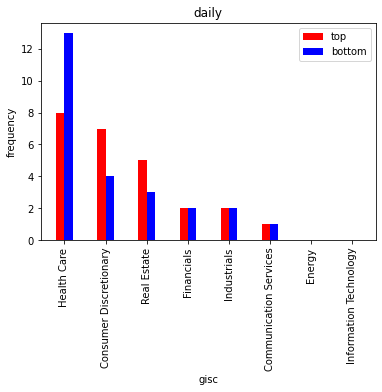

In [64]:
top_25 = dict(top_gain_loss_weekly["GICS"].head(25).value_counts())
bottom_25 = dict(top_gain_loss_weekly["GICS"].tail(25).value_counts())
labels = set(list(top_25.keys()) + list(bottom_25.keys()))
labels
for lab in labels:
    if lab in top_25:
        pass
    else:
        top_25[lab] = 0
    if lab in bottom_25:
        pass
    else:
        bottom_25[lab] = 0
        # top,bottom
w = 0.2
ind = np.arange(len(labels))
ind2 = [i+w for i in ind]
plt.bar(ind,top_25.values(),w,color="r",label="top")
plt.bar(ind2,bottom_25.values(),w,color="b",label="bottom")
plt.xlabel("gisc")
plt.ylabel("frequency")
plt.xticks(ind+w/2,labels,rotation=90)
plt.title("daily")
plt.legend()

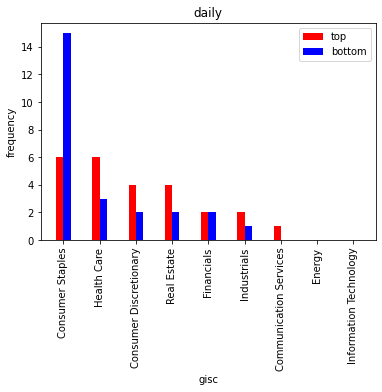

In [65]:
top_25 = dict(top_gain_loss_monthly["GICS"].head(25).value_counts())
bottom_25 = dict(top_gain_loss_monthly["GICS"].tail(25).value_counts())
labels = set(list(top_25.keys()) + list(bottom_25.keys()))
labels
for lab in labels:
    if lab in top_25:
        pass
    else:
        top_25[lab] = 0
    if lab in bottom_25:
        pass
    else:
        bottom_25[lab] = 0
        # top,bottom
w = 0.2
ind = np.arange(len(labels))
ind2 = [i+w for i in ind]
plt.bar(ind,top_25.values(),w,color="r",label="top")
plt.bar(ind2,bottom_25.values(),w,color="b",label="bottom")
plt.xlabel("gisc")
plt.ylabel("frequency")
plt.xticks(ind+w/2,labels,rotation=90)
plt.title("daily")
plt.legend()

In [66]:
import base64


def spark_line(data, figsize=(4, 0.25), **kwags):
    """
    Returns a HTML image tag containing a base64 encoded sparkline style plot
    """
    data = list(data)

    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwags)
    ax.plot(data)
    for k,v in ax.spines.items():
        v.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.plot(len(data) - 1, data[len(data) - 1], 'r.')

    ax.fill_between(range(len(data)), data, len(data)*[min(data)], alpha=0.1)

    img = io.BytesIO()
    plt.savefig(img, transparent=True, bbox_inches='tight')
    img.seek(0)
    plt.close()

    return base64.b64encode(img.read()).decode("UTF-8")

In [67]:
top_four = list()
top_2 = top_gain_loss_daily.head(2)
for sym in top_2["symbol"]:
    tsym = daily_samp[sym].sort_values().index[0]
    top_four.append(sym)
    top_four.append(tsym)
all_values = list()
for num in top_four:
    val = list(daily_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
with open("spark1.html", "a") as file:
        file.write('<div>Daily top</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

bottom_four = list()
bottom_2 = top_gain_loss_daily.tail(2)
for sym in bottom_2["symbol"]:
    tsym = daily_samp[sym].sort_values().index[0]
    bottom_four.append(sym)
    bottom_four.append(tsym)
all_values = list()
for num in bottom_four:
    val = list(daily_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
with open("spark1.html", "a") as file:
        file.write('<div>Daily bottom</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

In [68]:
top_four = list()
top_2 = top_gain_loss_weekly.head(2)
for sym in top_2["symbol"]:
    tsym = weekly_samp[sym].sort_values().index[0]
    top_four.append(sym)
    top_four.append(tsym)
all_values = list()
for num in top_four:
    val = list(weekly_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
with open("spark1.html", "a") as file:
        file.write('<div>Weekly top</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

bottom_four = list()
bottom_2 = top_gain_loss_weekly.tail(2)
for sym in bottom_2["symbol"]:
    tsym = weekly_samp[sym].sort_values().index[0]
    bottom_four.append(sym)
    bottom_four.append(tsym)
all_values = list()
for num in bottom_four:
    val = list(weekly_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
with open("spark1.html", "a") as file:
        file.write('<div>Weekly bottom</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

In [69]:
top_four = list()
top_2 = top_gain_loss_monthly.head(2)
for sym in top_2["symbol"]:
    tsym = monthly_samp[sym].sort_values().index[0]
    top_four.append(sym)
    top_four.append(tsym)
all_values = list()
for num in top_four:
    val = list(monthly_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
with open("spark1.html", "a") as file:
        file.write('<div>Monthly top</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

bottom_four = list()
bottom_2 = top_gain_loss_monthly.tail(2)
for sym in bottom_2["symbol"]:
    tsym = monthly_samp[sym].sort_values().index[0]
    bottom_four.append(sym)
    bottom_four.append(tsym)
all_values = list()
for num in bottom_four:
    val = list(monthly_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
with open("spark1.html", "a") as file:
        file.write('<div>Monthly bottom</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

In [71]:
import pdfcrowd

client = pdfcrowd.HtmlToPdfClient('demo', 'ce544b6ea52a5621fb9d55f8b542d14d')
client.convertFileToFile('spark1.html', 'spark1.pdf')